# Predicting regional COVID-19 hospital admissions in Sweden using mobility data
This notebook accompanies the manuscript "Predicting regional COVID-19 hospital admissions in Sweden using mobility data" and contains code for generain. To run it requires the following files: "statistik-covid19-inskrivna.xlsx", "VT.xlsx","ST.xlsx" and "param_IC.pkl".

Questions and comments: gerlee@chalmers.se

In [26]:
#importing modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d

In [27]:
#Parameters
n=20
startvecka=10-4 #start week
Tmax=48 #length of prediction
pv=0.023 #fraction of infected that are admitted

rho=7*1/5.1 #latency period
gamma=7*1/5 #recovery rate

delay=3#2.5 #delay from infection to admission

In [28]:
#Load data from Västtrafik
df = pandas.read_excel('VT.xlsx') #read excel-file
values = df['Unnamed: 4'].values 
diff = np.array(values[4:]) 
diff=np.insert(diff,0,[0.2,0.2]) #Set baseline travel
T=np.arange(7,7+len(diff),1)
resfkn = interp1d(T-startvecka,diff,kind="linear",fill_value="extrapolate") #create function

#Load data from Google
df = pandas.read_csv('2020_SE_Region_Mobility_Report.csv') #read excel-file
temp2=df.loc[df['iso_3166_2_code']=='SE-O']
transit=temp2['transit_stations_percent_change_from_baseline'].values 
dagar=np.arange(46,46+len(transit)) #create array of days corresponding to google data

tv=np.ceil(dagar/7)
gveckor=np.unique(tv)
k=0
Tr=np.zeros(int(max(gveckor)-min(gveckor))+1)

for i in gveckor:
    ind=tv==i
    Tr[k]=np.mean(transit[ind])/100
    k=k+1

    init=0.2 #0.1 innan
    Tr[0:2]=[init,init]

    Trfkn_vgr = interp1d(gveckor-startvecka,Tr,kind="linear",fill_value="extrapolate") #create function

In [29]:
#time-dependent infectivity
def beta(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)

In [30]:
#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b,transit_fkn)*x3/N
    dx2 = x1*beta(t-lag,a,b,transit_fkn)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    
    return [dx1, dx2, dx3, dx4]

In [31]:
#define output from model
def pred_inlagda(t,a,b):
    x0 = [N-1,0,1,0] #initial conditions
    x = odeint(dx, x0, t,args=(a,b,delay))
    return pv*x[:,2]

In [33]:
def getData(namn,ffall):
    temp=regioner.loc[regioner['region']==namn] #find the right row
    index=temp['index'].values #find the region index
    N=temp['population'].values #find population size of region

    R = file.iloc[index[0]] 
    R=R.replace(' ','X') #replace missing data with 0
    R=R.replace('X',0) 
    R=R.replace('IU',0) 
    ind = np.arange(3,len(R),2) 
    I = R.iloc[ind].values #extract admissions
    I=I[:-2] #remove last (incomplete) data point
    padding = np.zeros(10-ffall+3) 
    I=np.insert(I,0,padding) 
    veckor = np.arange(0,len(I),1) #create array of week numbers
    
    return I,veckor,N

In [34]:
#Load Google mobility data
def loadMobility(namn,svecka):
    df = pandas.read_csv('2020_SE_Region_Mobility_Report.csv') 
    temp=regioner.loc[regioner['region']==namn] 
    kod=temp['Regionkod'].values 
    temp2=df.loc[df['iso_3166_2_code']==kod[0]]
    transit=temp2['transit_stations_percent_change_from_baseline'].values 
    dagar=np.arange(46,46+len(transit))
    tv=np.ceil(dagar/7)
    
    
    gveckor=np.unique(tv)
    k=0
    Tr=np.zeros(int(max(gveckor)-min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    Trfkn = interp1d(gveckor-svecka,Tr,kind="linear",fill_value="extrapolate")
    return Trfkn

In [35]:
#fit model to data
def fitModel(veckor,I,astart,bstart):
    fit, cov = curve_fit(pred_inlagda,veckor,I,bounds=([1,1],[12, 12]),p0=(astart,bstart))
    P=pred_inlagda(veckor,fit[0],fit[1])
    E=np.sqrt(np.sum((P-I)**2)/len(I))/np.amax(I)
    return fit[0],fit[1],E

            region  index  population Regionkod   Area  Första fall
0            Sthlm      8     2389923     SE-AB   6524            9
1              VGR      9     1725881      SE-O  23800            9
2            Skåne     10     1387650      SE-M  10968            9
3     Östergötland     11      467095      SE-E  10559            9
4        Jönköping     12      364750      SE-F   8190            9
5     Södermanland     13      299101      SE-D  10437            9
6          Uppsala     14      387628      SE-C   5427            9
7        Gävleborg     15      287660      SE-X   8504            9
8      Västmanland     16      277074      SE-U   6075            9
9           Örebro     17      305726      SE-T  28029            9
10      Norrbotten     18      249768     SE-BD  18118            9
11         Dalarna     19      287806      SE-W  17519            9
12  Västernorrland     20      244855      SE-Y   5118            9
13        Värmland     21      282840      SE-S 

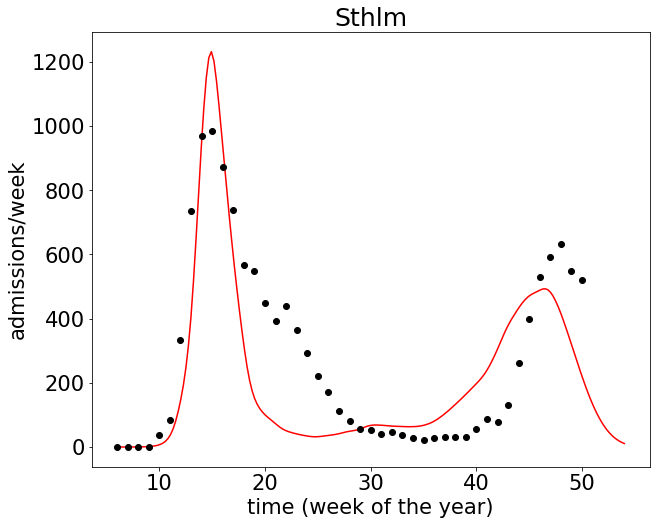

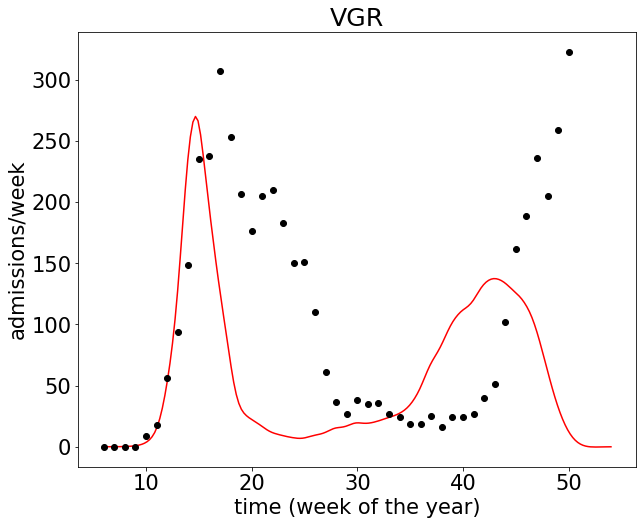

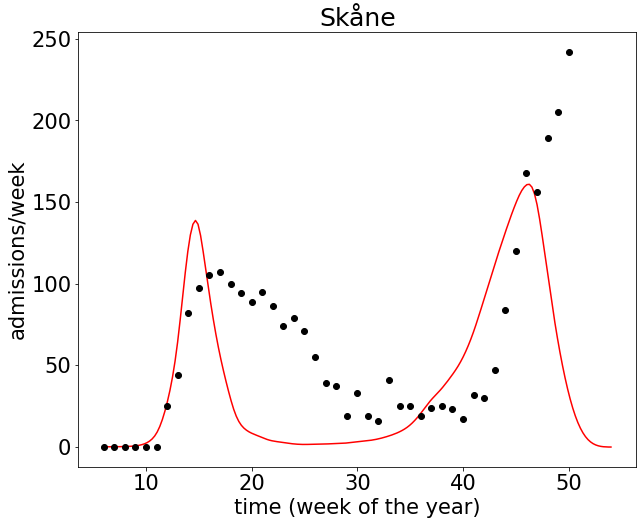

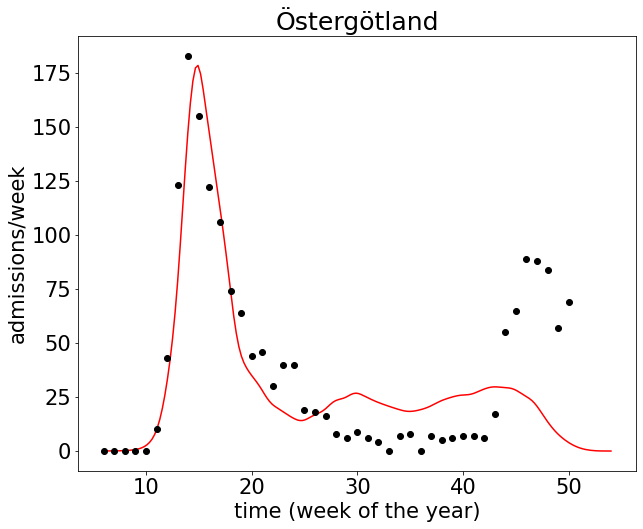

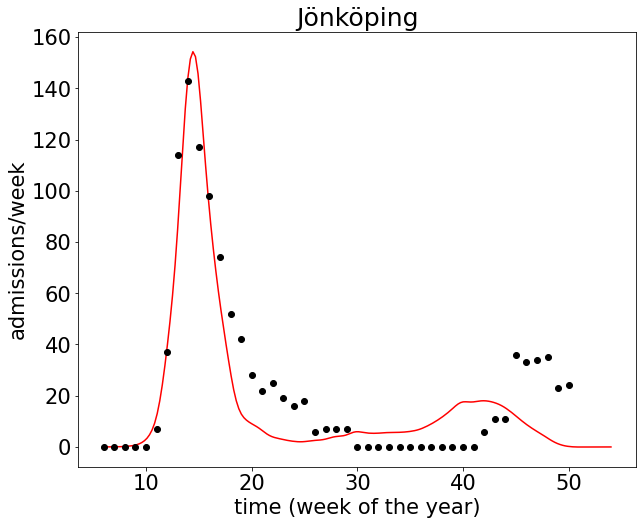

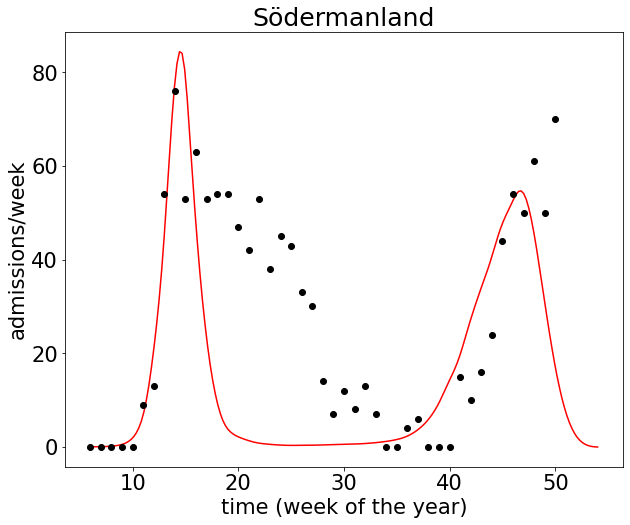

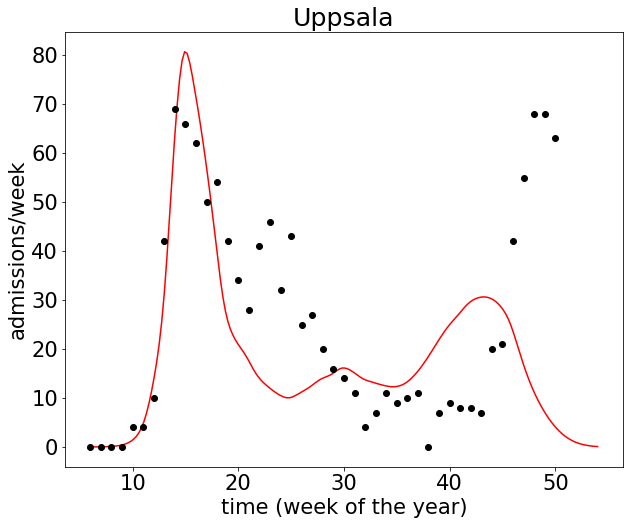

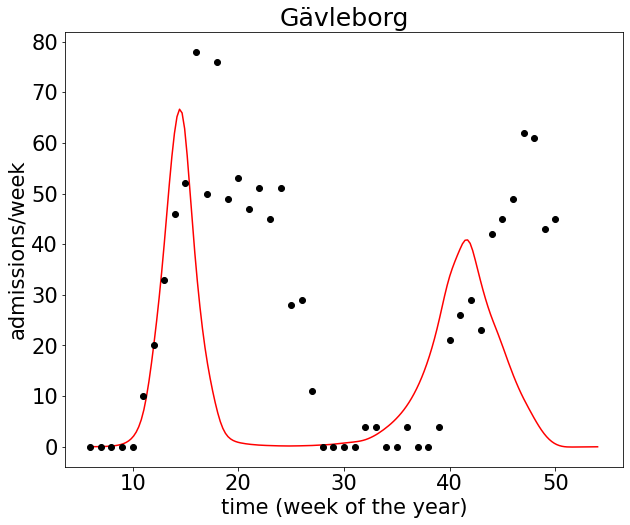

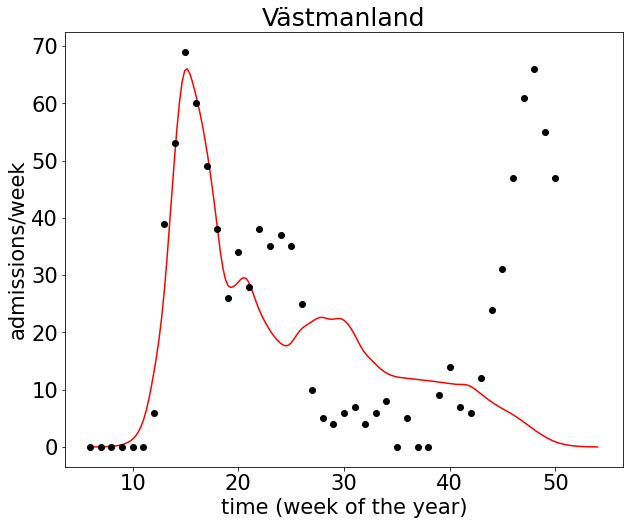

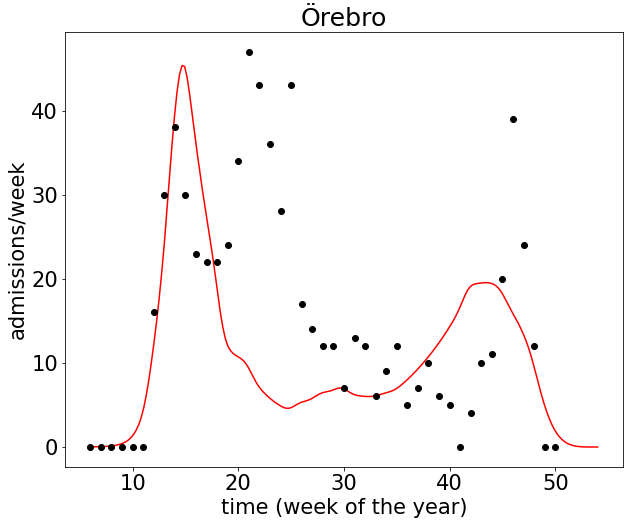

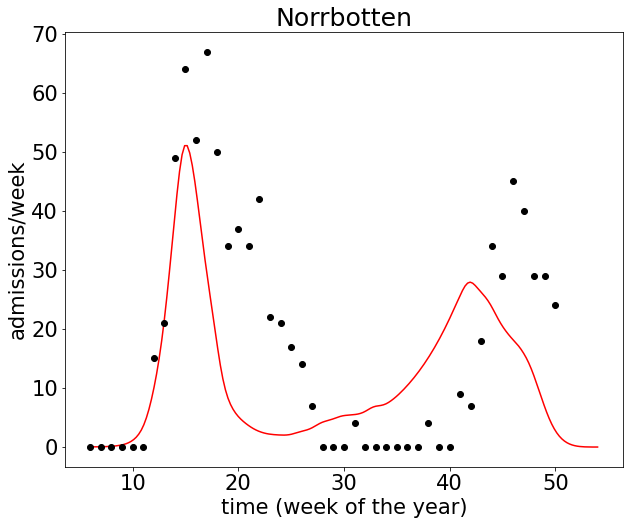

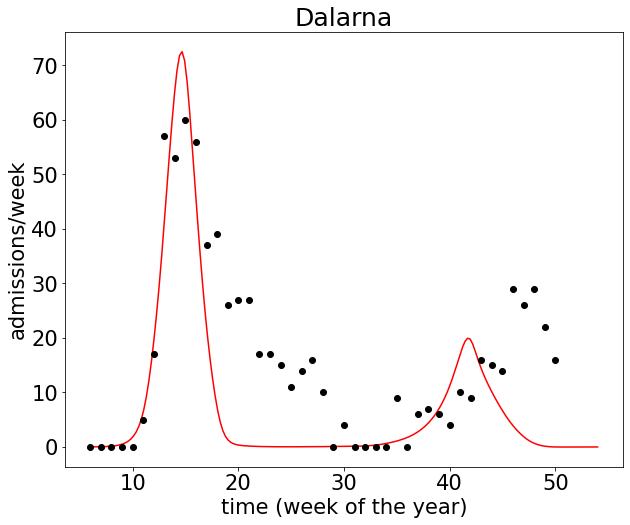

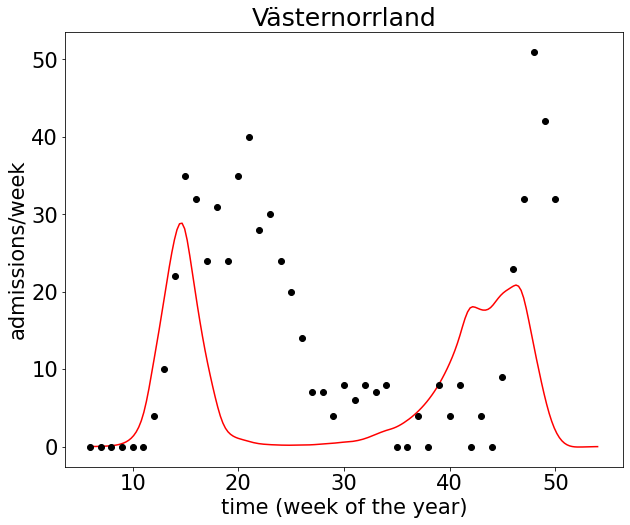

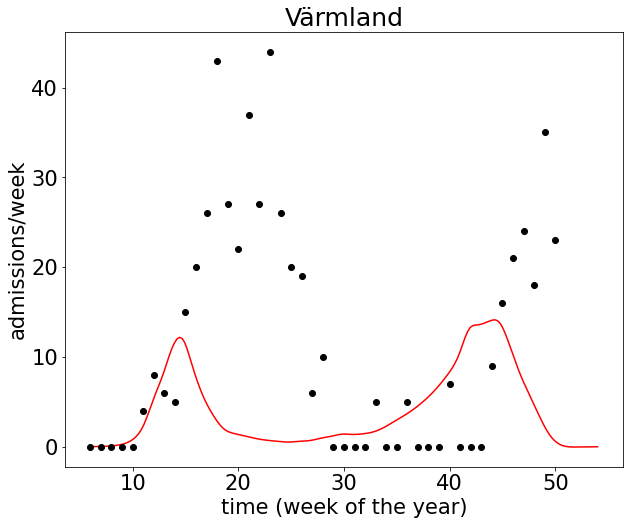

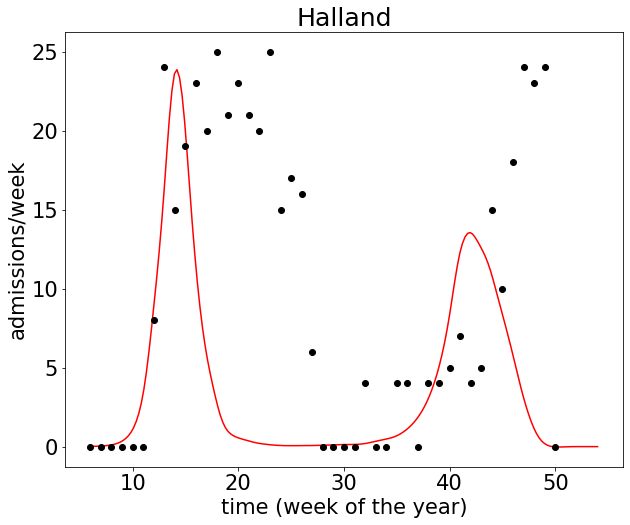

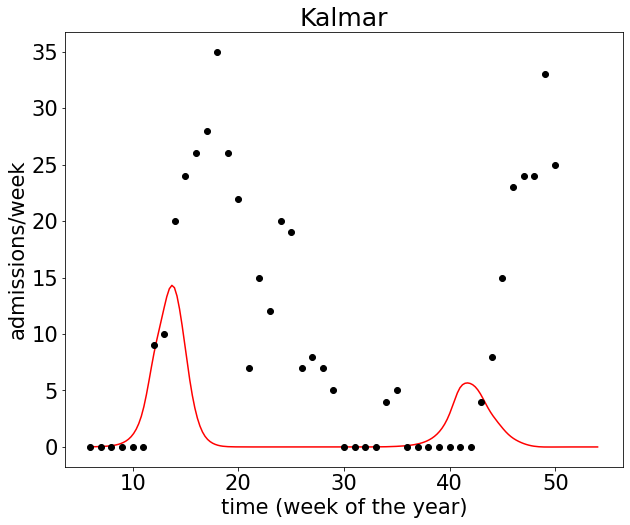

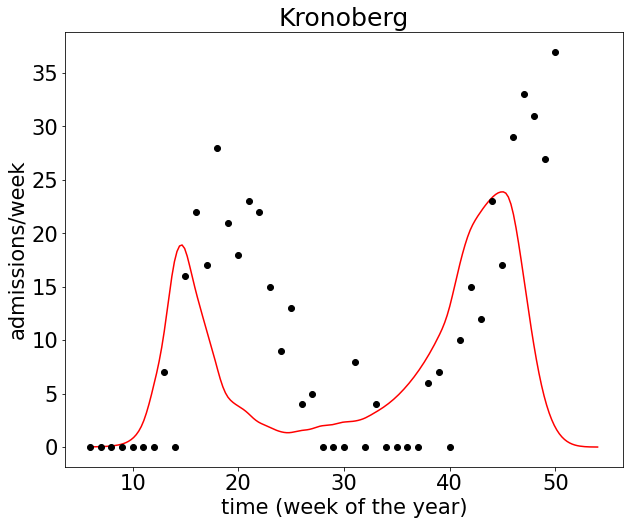

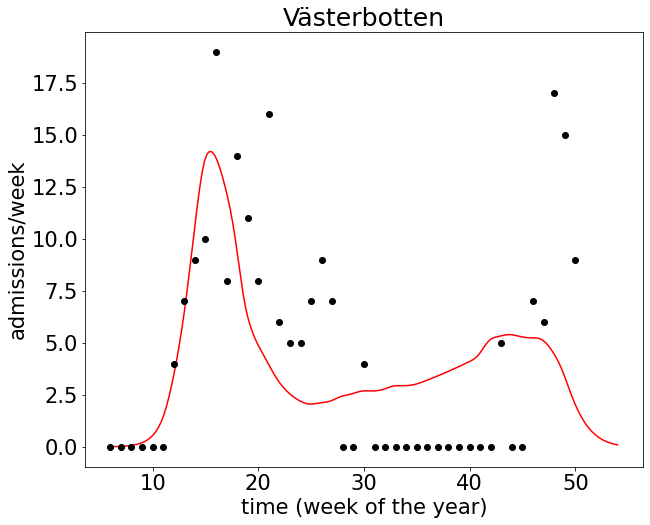

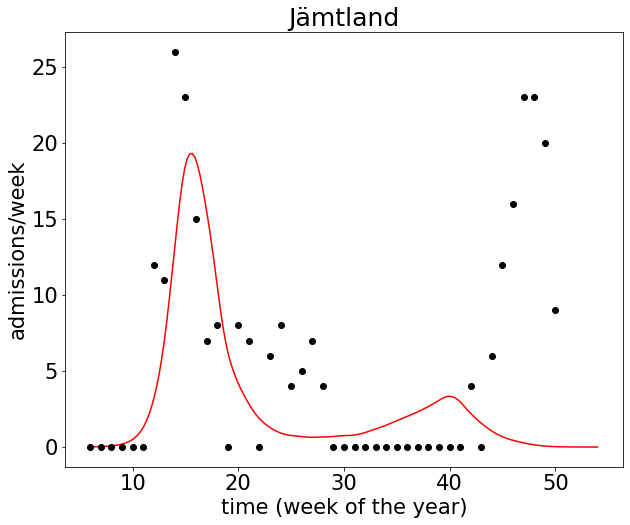

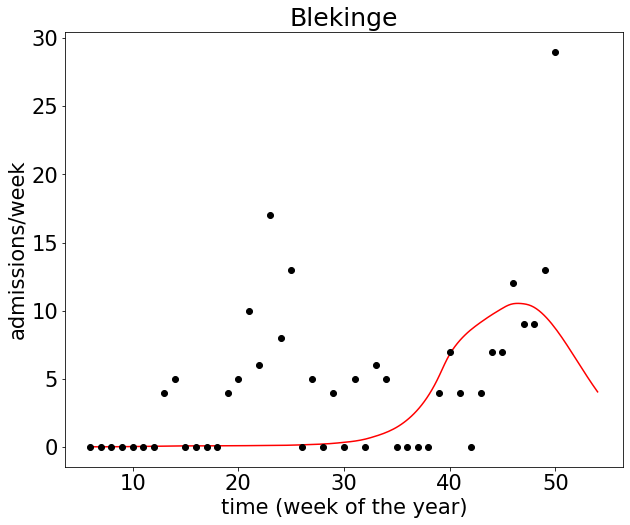

In [11]:
file = pandas.read_excel('statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård")
data = [['Sthlm', 8,2389923], ['VGR', 9,1725881], ['Skåne', 10,1387650],['Östergötland',11,467095],['Jönköping',12,364750],['Södermanland',13,299101],['Uppsala',14,387628],['Gävleborg',15,287660],['Västmanland',16,277074],['Örebro',17,305726],['Norrbotten',18,249768],['Dalarna',19,287806],['Västernorrland',20,244855],['Värmland',21,282840],['Halland',22,336132],['Kalmar',23,245992],['Kronoberg',24,202163],['Västerbotten',25,273061],['Jämtland',26,130972],['Blekinge',27,159349],['Gotland',28,60106]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index','population']) 
regionkod=['SE-AB','SE-O','SE-M','SE-E','SE-F','SE-D','SE-C','SE-X','SE-U','SE-T','SE-BD','SE-W','SE-Y','SE-S','SE-N','SE-H','SE-G','SE-AC','SE-Z','SE-K','SE-I']
regioner['Regionkod'] = regionkod
yta=np.array([6524,23800,10968,10559,8190,10437,5427,8504,6075,28029,18118,17519,5118,54665,97239,11165,21549,8424,2931,48935,3135]) #area of region
regioner['Area']=yta
ffall = 9*np.ones(21).astype(int) #week number when first case was recorded
regioner['Första fall'] = ffall 
startvecka = ffall - 3

regioner.drop(regioner.index[[20]],inplace=True) #remove Gotland
print(regioner)

namn = regioner['region'].values
t=np.linspace(0,Tmax,200)

regs = pandas.read_pickle('param_IC.pkl') #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

A=np.array([])
B=np.array([])
E=np.array([])

#Loop over regions
k=0
for R in namn:
    print(R)
    I,veckor,N = getData(R,ffall[k])
    transit_fkn=loadMobility(R,startvecka[k])
    a,b,e = fitModel(veckor,I,astart[k],bstart[k])
    pred = pred_inlagda(t,a,b)
    A=np.append(A,a)
    B=np.append(B,b)
    E=np.append(E,e)
    print(a,b)
    
    #Plot and save figure
    fig, axes = plt.subplots(1,1,figsize=(10,8))
    axes.plot(t+startvecka[k],pred,'r',label="Prediktion med resor") 
    axes.plot(veckor+startvecka[k],I,'ko',label="Inlagda")
    axes.set_xlabel('time (week of the year)')
    axes.set_ylabel('admissions/week')
    axes.set_title(R)
    fig.savefig(R+".pdf",format='pdf')
    k=k+1
    
regioner['a'] = A
regioner['b'] = B
regioner['E'] = E
regioner.to_pickle('regioner.pkl')  #save results in dataframe



In [13]:
print(regioner)

            region  index  population Regionkod   Area  Första fall         a  \
0            Sthlm      8     2389923     SE-AB   6524            9  4.738644   
1              VGR      9     1725881      SE-O  23800            9  3.888239   
2            Skåne     10     1387650      SE-M  10968            9  3.685821   
3     Östergötland     11      467095      SE-E  10559            9  3.785171   
4        Jönköping     12      364750      SE-F   8190            9  3.441260   
5     Södermanland     13      299101      SE-D  10437            9  3.513214   
6          Uppsala     14      387628      SE-C   5427            9  3.580967   
7        Gävleborg     15      287660      SE-X   8504            9  3.118446   
8      Västmanland     16      277074      SE-U   6075            9  3.517167   
9           Örebro     17      305726      SE-T  28029            9  3.263866   
10      Norrbotten     18      249768     SE-BD  18118            9  3.201139   
11         Dalarna     19   

In [39]:
df = pandas.read_pickle('regioner.pkl')
yta=np.array([6524,23800,10968,10559,8190,10437,5427,8504,6075,28029,18118,17519,5118,54665,97239,11165,21549,8424,2931,48935])
df['Area']=yta

df.drop('index',axis='columns', inplace=True)
df.drop('Regionkod',axis='columns', inplace=True)
df.drop('Första fall',axis='columns', inplace=True)
df = df[['region','population','Area','a','b','E']]

LinregressResult(slope=0.00011567264820966457, intercept=-7.451912318969256, rvalue=0.8661044245051898, pvalue=7.999136488528742e-07, stderr=1.573530817936148e-05)

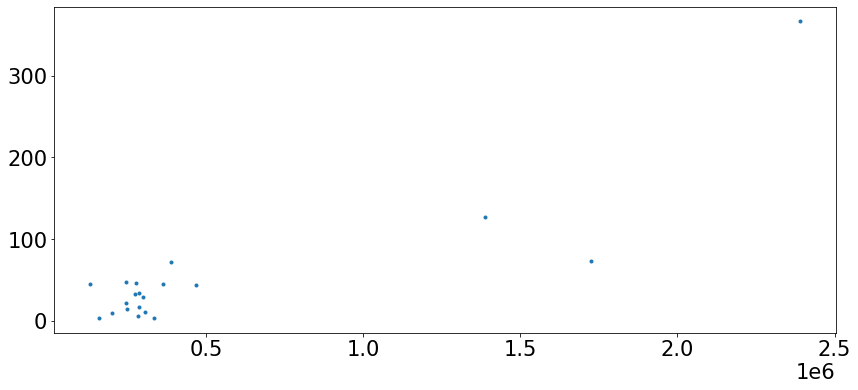

In [41]:
#Here we test correlations between error, estimated parameters and region properties
E=df['E'].values
N=df['population'].values
area=df['Area'].values
A=df['a'].values
B=df['b'].values
fig, axes = plt.subplots(1,1,figsize=(14,6))
axes.plot(N,N/area,'.')
from scipy.stats import linregress
linregress(N,N/area)